In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import sys,os
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import torch.utils
import cv2

In [3]:
import torch
from torch.utils.data import Dataset, DataLoader, TensorDataset
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image

In [4]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from random import randint

In [5]:
device = torch.device("cuda")
#device = torch.device("cpu")
print(device)

cuda


In [6]:
path = "/content/drive/My Drive/cv_project/"

In [7]:
x_train = np.load(path+'/x_train.npy')
y_train = np.load(path+'/y_train.npy')
x_val = np.load(path+'/x_val.npy')
y_val = np.load(path+'/y_val.npy')

In [8]:
x_train.shape

(14952, 1, 48, 48)

In [9]:
x_val.shape

(1662, 1, 48, 48)

In [10]:
mean= x_train.mean()
std= x_train.std()
print(mean)
print(std)

0.49325109310851223
0.23277932407558524


In [11]:
np.save("/content/drive/My Drive/cv_project/mean.npy",mean)
np.save("/content/drive/My Drive/cv_project/std.npy",std)

In [12]:
x_train = torch.Tensor(x_train)
y_train = torch.Tensor(y_train)

In [13]:
x_val = torch.Tensor(x_val)
y_val = torch.Tensor(y_val)

In [14]:
class myModel(nn.Module):
  def __init__(self):
    super(myModel , self).__init__()
     
    self.conv1 = nn.Conv2d(1,  32,  kernel_size=3 )
    #self.pool1  = nn.MaxPool2d(2,2)

    self.conv2 = nn.Conv2d(32,  64, kernel_size=3 )
    self.pool2  = nn.MaxPool2d(2,2)
      
    self.conv3 = nn.Conv2d(64, 32, kernel_size=3 )
    self.pool3  = nn.MaxPool2d(2,2)

    self.linear1 = nn.Linear(3200, 64)
    self.linear2 = nn.Linear(64,16)
    #self.linear3 = nn.Linear(64,16)
    self.dropout = nn.Dropout(p=0.4)
        
  def forward(self, x):

    x = self.conv1(x)
    x = F.relu(x)
    x = self.conv2(x)
    x = F.relu(x)
    x = self.pool2(x)

    x = self.conv3(x)
    x = F.relu(x)
    x = self.pool3(x)

    x = x.view(-1, 3200)

    x = self.linear1(x)
    x = F.relu(x)
    x = self.dropout(x)
    x = self.linear2(x)
    #x = F.relu(x)
 

        
    return x

In [15]:
def eval_on_val_set():
    bs=6
    running_loss=0
    running_acc=0
    num_batches=0
    model.eval()
    for i in range(0,y_val.shape[0],bs):

        minibatch_data =  x_val[i:i+bs]
        minibatch_label= y_val[i:i+bs].long()

        minibatch_data=minibatch_data.to(device)
        minibatch_label=minibatch_label.to(device)
        
        inputs = (minibatch_data - mean)/std

        scores = model(inputs) 

        loss = criterion(scores, minibatch_label)

        running_loss += loss.detach().item()
        _, predictions = torch.max(scores.data, 1)
        running_acc += (predictions == minibatch_label).sum().item()

        num_batches += 1

    lo =  running_loss/num_batches
    acc = 100*running_acc/len(x_val)

    print('loss = {}  accuracy = {}'.format(lo,acc))

In [73]:
model = myModel()

In [17]:
mean=torch.tensor(mean)
std=torch.tensor(std)

In [74]:
mean = mean.to(device)
std = std.to(device)
model = model.to(device)

In [75]:
bs = 24
in_channel = 1
num_classes = 16
learning_rate = 0.15
num_epochs = 30

In [76]:
criterion = nn.CrossEntropyLoss()


In [77]:
losses=[]
accuracy=[]
for epoch in range(num_epochs):
  
    model.train()
    # divide the learning rate by 2 at epoch 10, 14 and 18
    #if epoch%5==0 and epoch!=0:
    #    learning_rate = 0.25

   # create a new optimizer at the beginning of each epoch: give the current learning rate.   
    optimizer=torch.optim.SGD( model.parameters() , lr=learning_rate )

    running_loss=0
    running_acc=0
    num_batches = 0

    # set the order in which to visit the image from the training set
    shuffled_indices=torch.randperm(x_train.shape[0])
    for count in range(0,x_train.shape[0],bs):
        
        optimizer.zero_grad()
        
        # create a minibatch       
        indices=shuffled_indices[count:count+bs]
        minibatch_data =  x_train[indices]
        minibatch_label=  y_train[indices].long()

        # send them to the gpu
        minibatch_data=minibatch_data.to(device)
        minibatch_label=minibatch_label.to(device)
        
        inputs = (minibatch_data - mean)/std
        inputs.requires_grad_()

        scores = model(inputs)
        
        loss = criterion(scores, minibatch_label)
        
        loss.backward()
        optimizer.step()

        running_loss += loss.detach().item()
        _, predictions = torch.max(scores.data, 1)
        running_acc += (predictions == minibatch_label).sum().item()

        num_batches += 1

    lo =  running_loss/num_batches
    losses.append(lo)
    acc = 100*running_acc/len(x_train)
    accuracy.append(acc)
    print('Epoch {} : loss = {}  accuracy = {}'.format(epoch,lo,acc))

Epoch 0 : loss = 1.9786876533808333  accuracy = 37.426431246655966
Epoch 1 : loss = 1.5116776815386874  accuracy = 49.45826645264847
Epoch 2 : loss = 1.3634654388764504  accuracy = 52.33413590155163
Epoch 3 : loss = 1.2860149575657485  accuracy = 54.34724451578384
Epoch 4 : loss = 1.2400151206057872  accuracy = 55.9055644729802
Epoch 5 : loss = 1.1859819830707716  accuracy = 57.82504012841091
Epoch 6 : loss = 1.1652294558085752  accuracy = 57.985553772070624
Epoch 7 : loss = 1.1475371104182248  accuracy = 58.41359015516319
Epoch 8 : loss = 1.126957346979726  accuracy = 59.22284644194757
Epoch 9 : loss = 1.124432040877748  accuracy = 59.704387372926696
Epoch 10 : loss = 1.0955154391582667  accuracy = 60.66078116639915
Epoch 11 : loss = 1.0939675561880415  accuracy = 60.4266987693954
Epoch 12 : loss = 1.085896155424715  accuracy = 60.59390048154093
Epoch 13 : loss = 1.0781809915795946  accuracy = 60.894863563402886
Epoch 14 : loss = 1.0790691027958932  accuracy = 61.175762439807386
Epoch

Text(0.5, 0, 'No. of epochs')

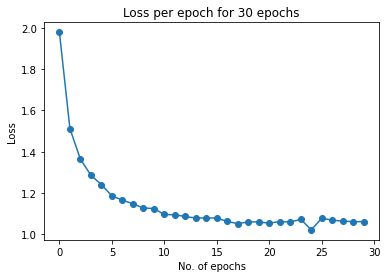

In [78]:
plt.plot(losses,'-o')
plt.title('Loss per epoch for 30 epochs')
plt.ylabel('Loss')
plt.xlabel('No. of epochs')

Text(0.5, 0, 'No. of epochs')

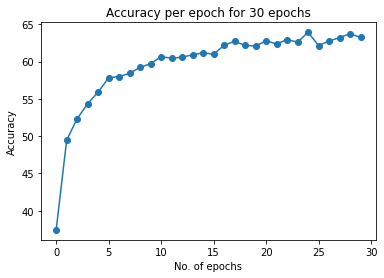

In [79]:
plt.plot(accuracy,'-o')
plt.title('Accuracy per epoch for 30 epochs')
plt.ylabel('Accuracy')
plt.xlabel('No. of epochs')

In [80]:
eval_on_val_set()

loss = 1.5442496934092003  accuracy = 52.82791817087846


In [ ]:
import pickle as pk
dest_path = "/content/drive/My Drive/cv_project/model.pkl"
#model = myModel()
pk.dump(model.to('cpu'),open(dest_path,'wb'))